In [1]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os, os.path
import keras
import time
import scipy.misc
import scipy.ndimage

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
from keras import backend as K
from keras.initializers import RandomUniform, RandomNormal

from PIL import Image

from tqdm import tqdm
from datetime import datetime

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5110)


In [2]:
# resolution of images

h = 75
w = 100

In [3]:
#Creates list of positiv files
positiv_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/pos/IMG_*.png')
#Finds the number of positiv files
positiv_len = len(positiv_list)
print("Size of positiv Sample: {}".format(positiv_len))

#Same but for negativ files
negativ_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/neg/IMG_*.png')
negativ_len = len(negativ_list)
print("Size of negativ Sample: {}".format(negativ_len))

Size of positiv Sample: 8590
Size of negativ Sample: 13875


In [4]:
X_posind = []
X_negind = []
X_posinu = []
X_neginu = []
X_posinl = []
X_neginl = []
X_posinr = []
X_neginr = []

X_pos = []
X_neg = []

for fname in tqdm(positiv_list):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_posind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_posinu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_posinr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_posinl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_pos.append(img) 
    
#Shuffling the order of the negtive images - required to avoid batches selecting similar images
np.random.shuffle(negativ_list)
ratio_pos_neg = 1
    
for fname in tqdm(np.random.choice(negativ_list, replace=False, size=int(len(X_pos) / ratio_pos_neg))):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_negind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_neginu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_neginr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_neginl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_neg.append(img)

100%|██████████| 8590/8590 [00:52<00:00, 162.08it/s]


In [5]:
X_posind = np.array(X_posind)
X_negind = np.array(X_negind)
X_posinu = np.array(X_posinu)
X_neginu = np.array(X_neginu)
X_posinl = np.array(X_posinl)
X_neginl = np.array(X_neginl)
X_posinr = np.array(X_posinr)
X_neginr = np.array(X_neginr)
X_pos = np.array(X_pos)
X_neg = np.array(X_neg)

In [6]:
X_all = np.concatenate((X_pos, X_neg), axis=0)
Y_all = np.concatenate( ( np.ones(len(X_pos)), np.zeros(len(X_neg)) ) , axis=0)
#X_all_trans = np.concatenate((X_pos, X_posind, X_posinu, X_posinl, X_posinr, X_neg, X_negind, X_neginu, X_neginl, X_neginr), axis=0)
#Y_all_trans = np_utils.to_categorical(np.concatenate((np.ones((5*positiv_len, 1)), np.zeros((5*negativ_len,1))), axis=0), 2)

In [7]:
X_all.shape

(17180, 75, 100)

In [8]:
Y_all.shape

(17180,)

In [9]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all = X_all[randomize]
Y_all = Y_all[randomize]

In [10]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_all[:200]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_all[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [11]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all))

# Separate in Training and Testing Sample
X_train = X_all[train_split:]
Y_train = Y_all[train_split:]

X_test = X_all[:train_split]
Y_test = Y_all[:train_split]

In [12]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_test[:100]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_test[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [13]:
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)

#Shape check (NumberofImages, Height, Width, Depth)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16321, 75, 100, 1)
(16321,)
(859, 75, 100, 1)
(859,)


### Test with lower resolution

In [64]:
x_new = 30
y_new = 40

In [65]:
X_all_30_40 = []
for img in X_all:
    X_all_30_40.append(scipy.misc.imresize(np.array(img),(x_new,y_new)))
    
X_all_30_40 = np.array(X_all_30_40)
Y_all_30_40 = Y_all

In [ ]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all_30_40 = X_all_30_40[randomize]
Y_all_30_40 = Y_all_30_40[randomize]

In [ ]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all_30_40))

# Separate in Training and Testing Sample
X_train_30_40 = X_all_30_40[train_split:]
Y_train_30_40 = Y_all_30_40[train_split:]

X_test_30_40 = X_all_30_40[:train_split]
Y_test_30_40 = Y_all_30_40[:train_split]

In [ ]:
X_train_30_40 = X_train_30_40.reshape(X_train_30_40.shape[0], x_new, y_new, 1)
X_test_30_40 = X_test_30_40.reshape(X_test_30_40.shape[0], x_new, y_new, 1)

# Data need to be normalised
* Mean and StdDev for each pixel over whole data set

In [14]:
X_train.shape

(16321, 75, 100, 1)

In [15]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

#means_30_40 = np.mean(X_train_30_40, axis=0)
#stds_30_40 = np.std(X_train_30_40, axis=0)

In [16]:
print(means.shape)
print(stds.shape)
#print(means_30_40.shape)
#print(stds_30_40.shape)

(75, 100, 1)
(75, 100, 1)


In [17]:
path_meanstd = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/MeansStdDev/'

if not os.path.exists(path_meanstd):
    os.makedirs(path_meanstd)
    print('Created path: {}'.format(path_meanstd))
                                            
#np.savetxt('../Data/Means_30_40.txt', means_30_40)
#np.savetxt('../Data/StdDev_30_40.txt', stds_30_40)
np.savetxt(path_meanstd +'Means_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', means)
np.savetxt(path_meanstd +'StdDev_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', stds)

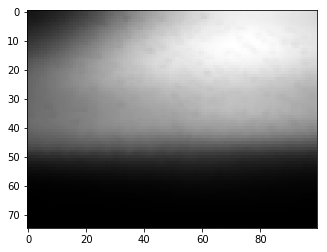

In [18]:
plt.imshow(np.squeeze(means), cmap='gray')
plt.savefig(path_meanstd + 'MeanImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

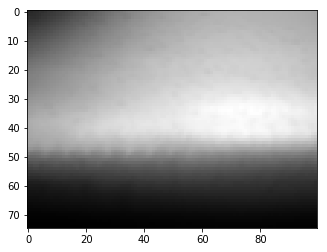

In [19]:
plt.imshow(np.squeeze(stds), cmap='gray')
plt.savefig(path_meanstd + 'StdImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

In [20]:
X_train_norm = np.array([(img-means)/stds for img in X_train])
X_test_norm = np.array([(img-means)/stds for img in X_test])

In [ ]:
#X_train_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_train_30_40])
#X_test_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_test_30_40])

# Let the training begin...

In [26]:
## Class to get loss and accuracy during training of NN

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))

In [22]:
input_shape= (h,w,1)
#input_shape_30_40= (x_new,y_new,1)

* initializer need to have mean = 0 and std 1/input_shape
* for successive layers output shape of previous layer will declare this

In [23]:
path_model = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/'

if not os.path.exists(path_model):
    os.makedirs(path_model)
    print('Created path: {}'.format(path_model))

In [123]:
model = Sequential()

# First Convolutional layer initialised with random input weights
model.add(Conv2D(16, (7,7), kernel_initializer=RandomNormal(mean=0, stddev=1/(h*w)), padding='valid', input_shape=input_shape, activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))
mult_shape1 = np.prod(model.layers[1].output_shape[1:])

# Second Convolutional layer
model.add(Conv2D(16, (3,3), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape1), padding='valid', activation='selu'))
# Reduce size a bit
model.add(MaxPooling2D(pool_size=(2,2)))

#Converting the 2D images to 1D vectors
model.add(Flatten())  
mult_shape2 = np.prod(model.layers[4].output_shape[1:])

# First Fully connected layer
model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape2)))
model.add(Dropout(0.2))
mult_shape3 = np.prod(model.layers[5].output_shape[1:])

#Second Fully connected layer
model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape3)))
model.add(Dropout(0.2))
mult_shape4 = np.prod(model.layers[6].output_shape[1:])

#Output layer
model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape4)))

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 69, 94, 16)        800       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 34, 47, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 45, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 22, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               1126600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
__________

In [27]:
#Defining optimiser and compiling the model

model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

history = LossHistory()

In [28]:
if True:
    model = load_model('../TrainedModels/2017-09-09/167_163_200_200_selu_50epochs.h5')

In [ ]:
model.fit(X_train_norm, Y_train,  batch_size=76, epochs=100, verbose=1, validation_split = 0.05, callbacks=[history])

#Evaluating trained model on test images
score = model.evaluate(X_test_norm, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

Train on 15504 samples, validate on 817 samples
Epoch 1/100
14592/15504 [===========================>..] - ETA: 2s - loss: 0.1944 - acc: 0.9394

In [ ]:
#To save trained NN - USE DIFFERENT NAME FOR NEW NETWORK
model.save(path_model + '167_163_200_200_selu_100epochs_retrained.h5')

In [ ]:
np.savetxt(path_model + '167_163_200_200_selu_100epochs_retrained_TrainingData.txt', np.transpose([history.accuracy, history.losses]))

In [ ]:
accuracy = np.array(history.accuracy)
losses = np.array(history.losses)

fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(accuracy[::10], color = 'b', marker='', ls='-')
ax[1].plot(losses[::10], color = 'm', marker='', ls='-')

ax[1].set_xlabel('batch number')
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')
#ax[1].set_yscale('log')

#### Score Distributions

In [144]:
# Get probs per image
probs = []

i=0 
for img in X_test_norm:
    #plt.imshow(np.squeeze(img), cmap='gray')
    
    img = np.reshape(img, [1,h,w,1])
    p = model.predict_proba(img, verbose=0)
    probs.append(np.squeeze(p))
    
    #name = "Good img" if Y_test[i, 1] == 1 else "Bad img"
    #plt.title('{}. Score: [{:.4f}, {:.4f}]'.format(name, p[0,0], p[0,1]))
    #plt.savefig('../Plots/TestImg/{}.png'.format(i))
    i+=1

probs = np.array(probs) 

In [145]:
label_pos = Y_test

In [146]:
score_pos = probs[label_pos == 1]
score_neg = probs[label_pos == 0]

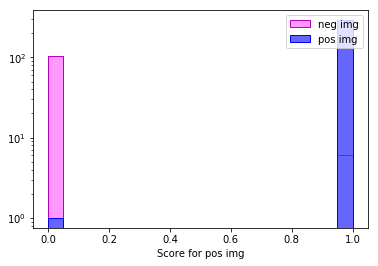

In [147]:
fig, ax = plt.subplots()

bins = np.arange(0, 1 + 0.05, 0.05)

ax.hist(score_neg, bins=bins, histtype='stepfilled', linewidth=1, edgecolor='m', color='#ff99ff', label='neg img')
ax.hist(score_pos, bins=bins, histtype='stepfilled', linewidth=1, edgecolor='b', color='#6666ff', label='pos img')

ax.hist(score_neg, bins=bins, histtype='step', linewidth=1, linestyle='-', edgecolor='m')
ax.hist(score_pos, bins=bins, histtype='step', linewidth=1, linestyle='-',edgecolor='b')

ax.set_xlabel("Score for pos img")
ax.set_yscale('log')

ax.legend(loc='best')

In [153]:
img = X_test[label_pos == 1]
img_false = img[score_pos < 0.5]
img_false.shape

(1, 75, 100, 1)

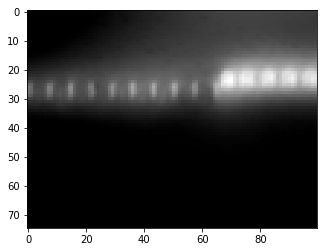

In [154]:
## wrongly classified pics:

for pic in img_false:
    plt.imshow(np.squeeze(pic), cmap='gray')
    plt.show()

In [99]:
score_pos.shape

(291,)

In [100]:
score_neg.shape

(111,)

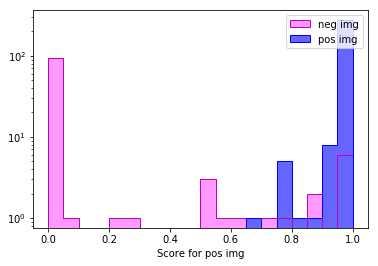

# Analyse saved model

In [ ]:
test_model = load_model('../TrainedModels/1613_1611_169_32_32_relu_woDropout_240_epochs.h5')

In [ ]:
#Evaluating trained model on test images
score = test_model.evaluate(X_test_norm, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

In [ ]:
accuracy, losses = np.genfromtxt('../Data/TrainingsData/1613_1611_169_32_32_relu_woDropout_240_epochs_TrainingData.txt', unpack=True)

In [ ]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(accuracy, color = 'b', marker='', ls='-')
ax[1].plot(losses, color = 'm', marker='', ls='-')

ax[1].set_xlabel('batch number')
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')
#ax[1].set_yscale('log')

# Score distribution for models on testdata

In [ ]:
test_model = load_model('../TrainedModels/')

In [ ]:
probs = []

for img in X_test_norm:
    img = np.reshape(img, [1,x,y,1])
    p = test_model.predict_proba(img, verbose=0)
    probs.append(np.squeeze(p))
    
probs = np.array(probs)    

In [ ]:
# Score
true = []
false = []
for p, t in zip(probs[:,0], Y_test[:,0]):
    if t == 1:
        true.append(p)
    if t == 0:
        false.append(p)
        
true = np.array(true)
false = np.array(false)

In [ ]:
fig, ax = plt.subplots()

ax.hist(false, bins=np.arange(0, 1 + 0.05, 0.05), histtype='stepfilled', linewidth=1, edgecolor='m', color='#ff99ff', alpha=1, label='neg img')
ax.hist(true, bins=np.arange(0, 1 + 0.05, 0.05), histtype='stepfilled', linewidth=1, edgecolor='b', color='#6666ff', alpha=1, label='pos img')

ax.hist(false, bins=np.arange(0, 1 + 0.05, 0.05), histtype='step', linewidth=1, linestyle='-', edgecolor='m', color='c', alpha=1)
ax.hist(true, bins=np.arange(0, 1 + 0.05, 0.05), histtype='step', linewidth=1, linestyle='-',edgecolor='b', color='b', alpha=1)

ax.set_yscale('log')

ax.legend(loc='best')

In [ ]:
X_test_norm.shape

In [ ]:
mask = [t<=0.4 for t in true]
len(true[mask])

In [ ]:
true[mask]

In [ ]:
len(t < 0.4 for t in true)